### Задание

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

1. Загрузите выборку passengers.csv. Примените `MinMaxScaler` 
из модуля `sklearn.preprocessing` в временному ряду `num_passengers`.

In [2]:
df=pd.read_csv('passengers.csv',index_col='date')
df

,num_passengers
date,
1949-1-1,112
1949-2-1,118
1949-3-1,132
1949-4-1,129
1949-5-1,121
...,...
1960-8-1,606
1960-9-1,508
1960-10-1,461


In [3]:
df['num_passengers']=df['num_passengers'].astype(np.float32)
df

,num_passengers
date,
1949-1-1,112.0
1949-2-1,118.0
1949-3-1,132.0
1949-4-1,129.0
1949-5-1,121.0
...,...
1960-8-1,606.0
1960-9-1,508.0
1960-10-1,461.0


In [4]:
scaler = MinMaxScaler()
print(scaler.fit(df))
df_scaled = df
df_scaled.num_passengers = scaler.transform(df).reshape(1, -1)[0]
df_scaled

MinMaxScaler()


,num_passengers
date,
1949-1-1,0.015444
1949-2-1,0.027027
1949-3-1,0.054054
1949-4-1,0.048263
1949-5-1,0.032819
...,...
1960-8-1,0.969112
1960-9-1,0.779923
1960-10-1,0.689189


2. Напишите функцию, которая принимает на вход временной ряд и ширину окна `k`, а возвращает `X`, `y` в формате `torch.Tensor`. Каждая строка объекта `X` должна содержать значения временного ряда $y_{t-k}, \ldots, y_{t-1}$, а на соответствующей позиции объекта `y` будет содержаться ответ $y_t$.

In [5]:
pas=df_scaled.values
def tensor(pas,k):
    y=pas[k:]
    x=np.array([]).reshape(0,k)
    for i in range(len(pas)-k):
        x=np.vstack([x,pas[i:i+k].reshape(1,-1)])
    return torch.tensor(y),torch.FloatTensor(x)

3. Воспользуйтесь готовой функцией с шириной окна `k=12`. Измените размерность `X` на (размер выборки, количество каналов `1`, ширина окна `k`).

In [6]:
k=12
y=tensor(pas,k)[0]
x=tensor(pas,k)[1]
x.shape

torch.Size([132, 12])

In [7]:
newx=x.reshape(x.shape[0],1,k)
newx.shape

torch.Size([132, 1, 12])

4. Разделите выборку на обучение и контроль. Для контроля оставьте 36 последних значений.

In [8]:
x_train=newx[:newx.shape[0]-36]
x_test=newx[-36:]

In [9]:
y_train=y[:y.shape[0]-36]
y_test=y[-36:]

5. Напишите класс для сверточной нейронной сети `CNN`. Нейронная сеть должна иметь следующую архитектуру:

- первый слой &ndash; сверточный (`torch.nn.Conv1D`): число каналов на вход &ndash; 1, на выход &ndash; 64, размер ядра свертки &ndash; 8, `stride=1`, функция активации &ndash; ReLU (`torch.nn.ReLU()`);
- второй слой &ndash; слой субдискретизации (`torch.nn.MaxPool1d`) с шириной окна 5;
- после применения сверточного слоя и слоя субдискретизации необходимо воспользоваться функцией `torch.flatten(..., 1)`, чтобы преобразовать полученный результат в вектор. Количество элементов вектора окажется равным 64 (подумайте, почему);
- полученный вектор передается на вход полносвязному слою `torch.nn.Linear` с 50 нейронами скрытого слоя, функция активации также ReLU;
- результат передается на выход сети (еще один `torch.nn.Linear` с 1 нейроном на выходном слое).

In [10]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv_layer1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=8, stride=1)
        self.pooling_layer1 = nn.MaxPool1d(kernel_size=5)

        self.linear_layer1 = nn.Linear(in_features=64, out_features=50)
        self.linear_layer2 = nn.Linear(in_features=50, out_features=1)
        
        self.relu = nn.ReLU()
        
    def forward(self, inputs):
        
        output_1 = self.relu(self.conv_layer1(inputs))
        output_2 = self.pooling_layer1(output_1)
        output_3=torch.flatten(output_2,1)
        
        output_4 = self.relu(self.linear_layer1(output_3))
        output = self.linear_layer2(output_4)
        
        return output

6. Для обучения сети задайте функцию активации `torch.nn.MSELoss()` и используйте метод `Adam` с шагом обучения `lr=0.001`. Обучите сверточную нейронную сеть на 1000 эпохах. Размер мини-батча &ndash; вся выборка. Во время обучения выводите величину функции потерь на обучающей выборке каждые 100 эпох.

In [11]:
model = CNN()
print(model)

CNN(
  (conv_layer1): Conv1d(1, 64, kernel_size=(8,), stride=(1,))
  (pooling_layer1): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (linear_layer1): Linear(in_features=64, out_features=50, bias=True)
  (linear_layer2): Linear(in_features=50, out_features=1, bias=True)
  (relu): ReLU()
)


In [12]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [13]:
# обучение
torch.manual_seed(10)

epochs = 1000
total_step = x_train.shape[0]
for epoch in range(epochs):
        outputs = model(x_train)
        loss = criterion(outputs, y_train)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print ('Epoch [{}/{}],Loss: {:.4f}'
               .format(epoch, epochs, loss.item()))

Epoch [0/1000],Loss: 0.0558
Epoch [1/1000],Loss: 0.0478
Epoch [2/1000],Loss: 0.0406
Epoch [3/1000],Loss: 0.0343
Epoch [4/1000],Loss: 0.0291
Epoch [5/1000],Loss: 0.0249
Epoch [6/1000],Loss: 0.0216
Epoch [7/1000],Loss: 0.0191
Epoch [8/1000],Loss: 0.0172
Epoch [9/1000],Loss: 0.0160
Epoch [10/1000],Loss: 0.0154
Epoch [11/1000],Loss: 0.0151
Epoch [12/1000],Loss: 0.0150
Epoch [13/1000],Loss: 0.0150
Epoch [14/1000],Loss: 0.0150
Epoch [15/1000],Loss: 0.0150
Epoch [16/1000],Loss: 0.0147
Epoch [17/1000],Loss: 0.0143
Epoch [18/1000],Loss: 0.0138
Epoch [19/1000],Loss: 0.0131
Epoch [20/1000],Loss: 0.0125
Epoch [21/1000],Loss: 0.0118
Epoch [22/1000],Loss: 0.0111
Epoch [23/1000],Loss: 0.0105
Epoch [24/1000],Loss: 0.0100
Epoch [25/1000],Loss: 0.0096
Epoch [26/1000],Loss: 0.0093
Epoch [27/1000],Loss: 0.0090
Epoch [28/1000],Loss: 0.0088
Epoch [29/1000],Loss: 0.0086
Epoch [30/1000],Loss: 0.0085
Epoch [31/1000],Loss: 0.0083
Epoch [32/1000],Loss: 0.0080
Epoch [33/1000],Loss: 0.0078
Epoch [34/1000],Loss: 0.

Epoch [287/1000],Loss: 0.0008
Epoch [288/1000],Loss: 0.0008
Epoch [289/1000],Loss: 0.0008
Epoch [290/1000],Loss: 0.0008
Epoch [291/1000],Loss: 0.0008
Epoch [292/1000],Loss: 0.0008
Epoch [293/1000],Loss: 0.0008
Epoch [294/1000],Loss: 0.0008
Epoch [295/1000],Loss: 0.0007
Epoch [296/1000],Loss: 0.0007
Epoch [297/1000],Loss: 0.0007
Epoch [298/1000],Loss: 0.0007
Epoch [299/1000],Loss: 0.0007
Epoch [300/1000],Loss: 0.0007
Epoch [301/1000],Loss: 0.0007
Epoch [302/1000],Loss: 0.0007
Epoch [303/1000],Loss: 0.0007
Epoch [304/1000],Loss: 0.0007
Epoch [305/1000],Loss: 0.0007
Epoch [306/1000],Loss: 0.0007
Epoch [307/1000],Loss: 0.0007
Epoch [308/1000],Loss: 0.0007
Epoch [309/1000],Loss: 0.0007
Epoch [310/1000],Loss: 0.0007
Epoch [311/1000],Loss: 0.0007
Epoch [312/1000],Loss: 0.0007
Epoch [313/1000],Loss: 0.0007
Epoch [314/1000],Loss: 0.0007
Epoch [315/1000],Loss: 0.0007
Epoch [316/1000],Loss: 0.0007
Epoch [317/1000],Loss: 0.0007
Epoch [318/1000],Loss: 0.0007
Epoch [319/1000],Loss: 0.0007
Epoch [320

Epoch [579/1000],Loss: 0.0003
Epoch [580/1000],Loss: 0.0003
Epoch [581/1000],Loss: 0.0003
Epoch [582/1000],Loss: 0.0003
Epoch [583/1000],Loss: 0.0003
Epoch [584/1000],Loss: 0.0003
Epoch [585/1000],Loss: 0.0003
Epoch [586/1000],Loss: 0.0003
Epoch [587/1000],Loss: 0.0003
Epoch [588/1000],Loss: 0.0003
Epoch [589/1000],Loss: 0.0003
Epoch [590/1000],Loss: 0.0003
Epoch [591/1000],Loss: 0.0003
Epoch [592/1000],Loss: 0.0003
Epoch [593/1000],Loss: 0.0003
Epoch [594/1000],Loss: 0.0003
Epoch [595/1000],Loss: 0.0003
Epoch [596/1000],Loss: 0.0003
Epoch [597/1000],Loss: 0.0003
Epoch [598/1000],Loss: 0.0003
Epoch [599/1000],Loss: 0.0003
Epoch [600/1000],Loss: 0.0003
Epoch [601/1000],Loss: 0.0003
Epoch [602/1000],Loss: 0.0003
Epoch [603/1000],Loss: 0.0003
Epoch [604/1000],Loss: 0.0003
Epoch [605/1000],Loss: 0.0003
Epoch [606/1000],Loss: 0.0003
Epoch [607/1000],Loss: 0.0003
Epoch [608/1000],Loss: 0.0003
Epoch [609/1000],Loss: 0.0003
Epoch [610/1000],Loss: 0.0003
Epoch [611/1000],Loss: 0.0003
Epoch [612

Epoch [892/1000],Loss: 0.0001
Epoch [893/1000],Loss: 0.0001
Epoch [894/1000],Loss: 0.0001
Epoch [895/1000],Loss: 0.0001
Epoch [896/1000],Loss: 0.0001
Epoch [897/1000],Loss: 0.0001
Epoch [898/1000],Loss: 0.0001
Epoch [899/1000],Loss: 0.0001
Epoch [900/1000],Loss: 0.0001
Epoch [901/1000],Loss: 0.0001
Epoch [902/1000],Loss: 0.0001
Epoch [903/1000],Loss: 0.0001
Epoch [904/1000],Loss: 0.0001
Epoch [905/1000],Loss: 0.0001
Epoch [906/1000],Loss: 0.0001
Epoch [907/1000],Loss: 0.0001
Epoch [908/1000],Loss: 0.0001
Epoch [909/1000],Loss: 0.0001
Epoch [910/1000],Loss: 0.0001
Epoch [911/1000],Loss: 0.0001
Epoch [912/1000],Loss: 0.0001
Epoch [913/1000],Loss: 0.0001
Epoch [914/1000],Loss: 0.0001
Epoch [915/1000],Loss: 0.0001
Epoch [916/1000],Loss: 0.0001
Epoch [917/1000],Loss: 0.0001
Epoch [918/1000],Loss: 0.0001
Epoch [919/1000],Loss: 0.0001
Epoch [920/1000],Loss: 0.0001
Epoch [921/1000],Loss: 0.0001
Epoch [922/1000],Loss: 0.0001
Epoch [923/1000],Loss: 0.0001
Epoch [924/1000],Loss: 0.0001
Epoch [925

7. Вызовите метод `.eval()` обученной модели, чтобы перейти к построению прогноза. Получите предсказания модели для тестовой выборки. Преобразуйте предсказания обратно к массиву numpy через метод `.data.numpy()`. С помощью метода `inverse_transform` у `MinMaxScaler` получите предсказания для исходного временного ряда.

In [14]:
model.eval()

CNN(
  (conv_layer1): Conv1d(1, 64, kernel_size=(8,), stride=(1,))
  (pooling_layer1): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (linear_layer1): Linear(in_features=64, out_features=50, bias=True)
  (linear_layer2): Linear(in_features=50, out_features=1, bias=True)
  (relu): ReLU()
)

In [15]:
y_pred=model(x_test).data.numpy()

In [16]:
y_pred=scaler.inverse_transform(y_pred)

8. Отобразите на графике исходный ряд и полученный прогноз.

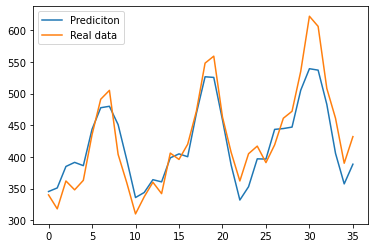

In [17]:
plt.plot(y_pred,label='Prediciton')
plt.plot(scaler.inverse_transform(y_test.reshape(1,-1))[0],label='Real data')
plt.legend()